In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk

# INTRODUCCIÓN

En esta práctica, trataremos de analizar un conjunto de datos referente a semillas de plantas a través de la técnica de "clustering". El clustering es un algoritmo de machine learning no supervisado que organiza y clasifica diferentes datos en grupos o clústeres basados en similitudes o patrones. A través de esta técnica, intentaremos agrupar estas semillas y encontrar esos patrones que las unen.

# ANÁLISIS DE LOS DATOS PARA CLUSTERING

Antes de realizar ninguna operación, es conveniente analizar los datos que estamos tratando de manera general. Además, inicializaremos la semilla que nos permitirá reproducir todos los resultados más adelante.

## Análisis básico

In [21]:
SEED = 100495861

In [22]:
df = pd.read_csv('semillas.csv')
df.sample(5)

,area,perimetro,compacidad,longitud,anchura,asimetria,surco,clase
120,20.24,16.91,0.8897,6.315,3.962,5.901,6.188,2
176,11.26,13.01,0.8355,5.186,2.710,5.335,5.092,3
52,14.49,14.61,0.8538,5.715,3.113,4.116,5.396,1
48,14.79,14.52,0.8819,5.545,3.291,2.704,5.111,1
76,17.32,15.91,0.8599,6.064,3.403,3.824,5.922,2


Como podemos comprobar visualmente, los datos de las semillas tienen los siguientes atributos:

**Área, Perímetro, Compacidad, Longitud, Anchura, Asimetría, Surco y Clase**

Para tener más información sobre estos datos, haremos un df.describe() que nos mostrará algunas de sus características.

df.describe()

A partir de este estudio simple, se puede identificar que:
- Tenemos 210 semillas.
- Existen un máximo de tres clases.
- El resto de los datos son floats, por lo que se necesita una mayor investigación.

## PCA (Principal Component Analysis)

Para entender mejor los datos, utilizaremos "Principal Component Analysis". Esta técnica reduce las dimensiones de los datos y además ordena sus atributos por importancia, por lo que podemos reducir ruido y encontrar patrones que los unen. Usándola, podremos visualizar sin problema los datos en 2D, lo que nos ayudará más adelante a elegir el scaler apropiado.

Empezaremos por definir X (los atributos) e Y (la variable objetivo). Para definir X, debemos evidentemente eliminar la columna "clase", ya que es lo que estamos tratando de averiguar. Es por ello que la convertiremos en nuestra variable Y.

In [23]:
X = df.drop(columns=["clase"])
y = df["clase"]

print(X.shape, X.columns)
print(y.shape)

(210, 7) Index(['area', 'perimetro', 'compacidad', 'longitud', 'anchura', 'asimetria',
       'surco'],
      dtype='object')
(210,)


## Elección de scaler

Necesitamos también un scaler que nos ayude a mantener nuestros datos en un rango consistente, de manera que podamos tratarlos con facilidad. Los scalers a considerar son:
- MinMax Scaler --> Escala los datos de 0 a 1
- Robust Scaler --> Escala los datos usando medianas y rangos intercuartílicos
- Standard Scaler --> Escala los datos restando la media y dividiendo por la desviación estándar

Para elegir uno, simplemente visualizaremos los clusters que nos dan al usar PCA en dos dimensiones con cada scaler y comprobaremos cuál es el que mejor separa los datos. Éste será nuestro scaler elegido.

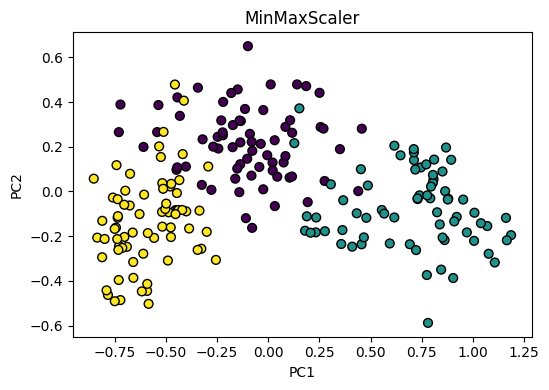

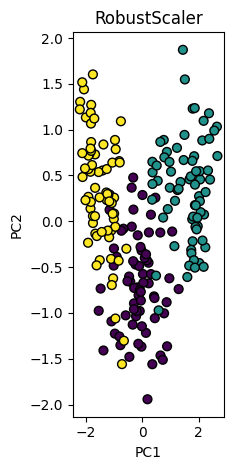

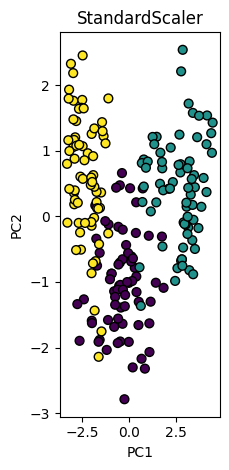

In [24]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

scalers = [MinMaxScaler(), RobustScaler(), StandardScaler()]
scaler_names = ["MinMaxScaler", "RobustScaler", "StandardScaler"]

plt.figure(figsize=(15, 4))

for i, (scaler, name) in enumerate(zip(scalers, scaler_names)):
    pipe = Pipeline([
        ("scaler", scaler),
        ("pca", PCA(n_components=2))
    ])
    X_reduced = pipe.fit_transform(X)

    plt.subplot(1, 3, i + 1)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, cmap="viridis", edgecolor="k", s=40)
    plt.title(name)
    plt.xlabel("PC1")
    plt.ylabel("PC2")

    plt.tight_layout()
    plt.show()

Como podemos comprobar, MinMax Scaler nos devuelve unos datos mucho menos compactos y mejor agrupados. Por ende, **elegimos MinMax Scaler para futuras operaciones**.

Como queremos los datos en dos dimensiones, es importante saber si con dos componentes tendremos suficiente para separar los clusters sin perder demasiada información. Utilizando la varianza explicada podremos comprobarlo.

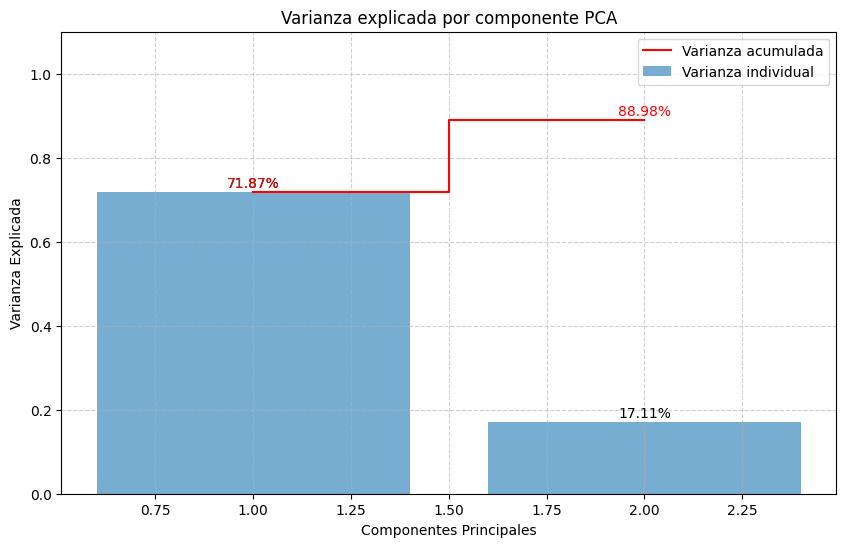

In [25]:
from sklearn.decomposition import PCA

# Varianza explicada y acumulada
pca = pipe.named_steps["pca"]
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)
    
# 1. Plot de Varianza Explicada y Acumulada
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.6, label='Varianza individual')
plt.step(range(1, len(cumulative_variance) + 1), cumulative_variance, where='mid', label='Varianza acumulada', color='red')
# Añadir valores exactos
for i, (ev, cv) in enumerate(zip(explained_variance, cumulative_variance)):
    plt.text(i + 1, ev + 0.01, f"{ev:.2%}", ha='center')
    plt.text(i + 1, cv + 0.01, f"{cv:.2%}", ha='center', color='red')
    
plt.xlabel('Componentes Principales')
plt.ylabel('Varianza Explicada')
plt.title('Varianza explicada por componente PCA')
plt.legend(loc='best')
plt.ylim(0, 1.1)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

Con sólo dos componentes somos capaces de explicar el **89% de la varianza**. Esto es muy importante de destacar, ya que no perderemos mucha información y podremos conseguir una serie de resultados muy buenos.

# APLICACIÓN DE TÉCNICAS

Una vez que ya tenemos los datos analizados y que hemos elegido el scaler que más nos conviene, podemos proceder a aplicar diferentes técnicas de clustering. Las técnicas que se usarán son:

- K-means
- Hierarchical
- DBScan

## K-means

El algoritmo K-Means se basa en encontrar las agrupaciones de los datos en base a un número K de centroides. Esta K es el hiperparámetro que debemos especificar. El algoritmo elegirá K puntos al azar y asignará cada punto del conjunto de datos al cluster cuyo centroide esté más cerca. Después recalcula los centroides de cada cluster como la media de todos los puntos del cluster y va repitiendo el proceso de manera iterativa hasta que los centroides no cambien o se llegue al número máximo de iteraciones.

Primero necesitamos encontrar un número adecuado para K. Para ello, vamos a utilizar las técnicas de codo y silueta.

### Gráfico de codo

La técnica del gráfico de codo nos muestra en el eje X el número de clusters (el hiperparámetro que queremos conseguir), y en el eje Y la inercia, que es la suma de distancias al cuadrado de cada punto a su centroide. Nuestro objetivo es identificar el K donde la inercia deja de disminuir significativamente (o el "codo").

Para ello, vamos a generar el gráfico.

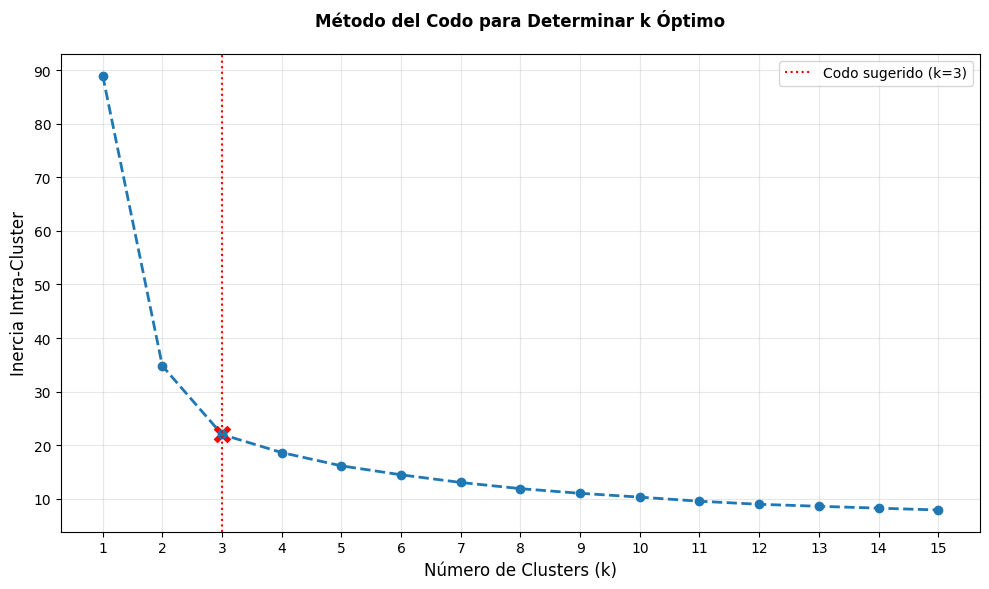

Número óptimo de clusters sugerido (codo): k = 3


In [26]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from kneed import KneeLocator


scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Rango de clusters a evaluar
range_n_clusters = range(1, 16)  # Desde 1 hasta 15 clusters
inertias = []

for k in range_n_clusters:
    kmeans = KMeans(
        n_clusters=k,
        n_init=20,          # Número de inicializaciones (para mayor estabilidad)
        random_state=42     # Semilla para reproducibilidad
    )
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

# Detección automática del codo
kneedle = KneeLocator(
    range_n_clusters, 
    inertias, 
    curve='convex', 
    direction='decreasing'
)
best_k = kneedle.elbow


plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, inertias, marker='o', linestyle='--', color='#1f77b4', linewidth=2)
plt.axvline(best_k, color='red', linestyle=':', label=f'Codo sugerido (k={best_k})')

# Ajustes estéticos
plt.title('Método del Codo para Determinar k Óptimo', pad=20, fontweight='bold')
plt.xlabel('Número de Clusters (k)', fontsize=12)
plt.ylabel('Inercia Intra-Cluster', fontsize=12)
plt.xticks(range_n_clusters)
plt.grid(True, alpha=0.3)
plt.legend()

plt.scatter(best_k, inertias[best_k-1], s=200, c='red', marker='X', edgecolors='white')

plt.tight_layout()
plt.show()

print(f"Número óptimo de clusters sugerido (codo): k = {best_k}")

Nuestro gráfico del codo es evidente: usando k = 3 conseguiríamos los resultados más adecuados.

Sinembargo, no podemos quedarnos sólo con eso. Utilizando el método de la silhueta podremos asegurarlo con más firmeza.

### Gráfico de silhueta

El análisis de silueta nos muestra en el eje X el número de clusters (K), y en el eje Y el coeficiente de silueta, que mide cómo de bien definidos están los clusters. Este coeficiente varía entre -1 y 1, donde los valores cercanos a 1 indican que los puntos están muy cerca de su centroide y lejos de otros clusters (clusters bien separados), los valores cercanos a 0 sugieren solapamiento entre clusters y los valores negativos implican que muchos puntos podrían estar asignados al cluster incorrecto.

Nuestro objetivo es identificar el K donde el coeficiente de silueta alcanza su valor máximo, ya que esto indica la configuración óptima donde los clusters están mejor definidos y separados entre sí.

Vamos a graficar los datos.

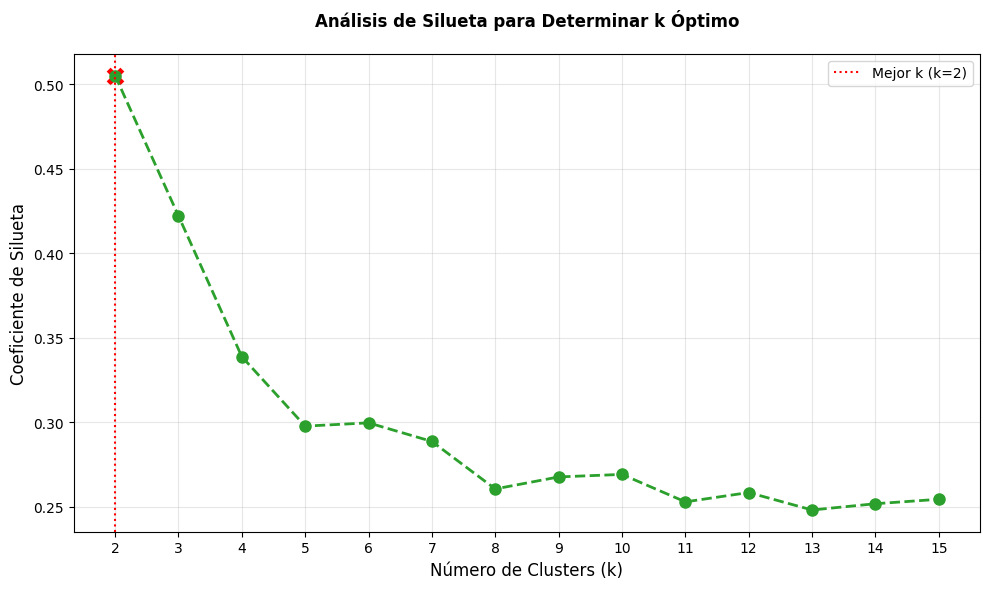

Número óptimo de clusters sugerido (silueta): k = 2
Coeficiente de silueta para k=2: 0.505


In [27]:
from sklearn.metrics import silhouette_score
from matplotlib.ticker import MultipleLocator
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

range_n_clusters = range(2, 16)  # La silueta no funciona con k=1
silhouette_scores = []

for k in range_n_clusters:
    kmeans = KMeans(
        n_clusters=k,
        n_init=20,
        random_state=42
    )
    cluster_labels = kmeans.fit_predict(X_scaled)
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)

best_k = range_n_clusters[np.argmax(silhouette_scores)]

plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, silhouette_scores, marker='o', linestyle='--', 
         color='#2ca02c', linewidth=2, markersize=8)
plt.axvline(best_k, color='red', linestyle=':', label=f'Mejor k (k={best_k})')

# Ajustes estéticos
plt.title('Análisis de Silueta para Determinar k Óptimo', pad=20, fontweight='bold')
plt.xlabel('Número de Clusters (k)', fontsize=12)
plt.ylabel('Coeficiente de Silueta', fontsize=12)
plt.xticks(range_n_clusters)
plt.gca().xaxis.set_major_locator(MultipleLocator(1))  # Mostrar todos los valores de k
plt.grid(True, alpha=0.3)
plt.legend()

plt.scatter(best_k, max(silhouette_scores), s=200, c='red', marker='X', edgecolors='white')

plt.tight_layout()
plt.show()

print(f"Número óptimo de clusters sugerido (silueta): k = {best_k}")
print(f"Coeficiente de silueta para k={best_k}: {max(silhouette_scores):.3f}")

A pesar de que el método del codo nos dió K=3, la silhueta nos dice que K debería ser 2. **¿A qué deberíamos hacer caso?**

Considerando que la variación del coeficiente de silhueta no es demasiado grande entre K=2 y K=3, y que el codo visualiza una diferencia mucho más grande entre estos dos parámetros, **es conveniente que elijamos K=3**.

### Aplicación del modelo

Una vez que ya conocemos el número apropiado de centroides, podemos proceder a la aplicación del modelo.

In [185]:
import matplotlib.pyplot as plt
import numpy as np

def plot_kmeans_2d(X_2d, modelo_kmeans):
    """
    Representa un único plot con los clusters KMeans y sus centroides.
    - X_2d: array (n_samples, 2) con tus dos componentes.
    - modelo_kmeans: modelo KMeans ya ajustado a X_2d.
    """

    # Predecir etiquetas de clusters
    y_pred = modelo_kmeans.predict(X_2d)
    
    # Crear figura y un solo eje
    fig, ax = plt.subplots(figsize=(8, 6))

    # Plot de cada cluster
    for label in np.unique(y_pred):
        ax.scatter(
            X_2d[y_pred == label, 0],
            X_2d[y_pred == label, 1],
            edgecolor='k',
            label=f"Cluster {label}"
        )

    # Añadir centroides
    ax.scatter(
        modelo_kmeans.cluster_centers_[:, 0],
        modelo_kmeans.cluster_centers_[:, 1],
        marker='*',
        s=200,
        c='black',
        label='Centroides'
    )

    # Ajustes de títulos y etiquetas
    ax.set_title('Clusters KMeans en 2D')
    ax.set_xlabel('Dimensión 1')
    ax.set_ylabel('Dimensión 2')
    ax.legend()

    plt.tight_layout()
    plt.show()

    return y_pred

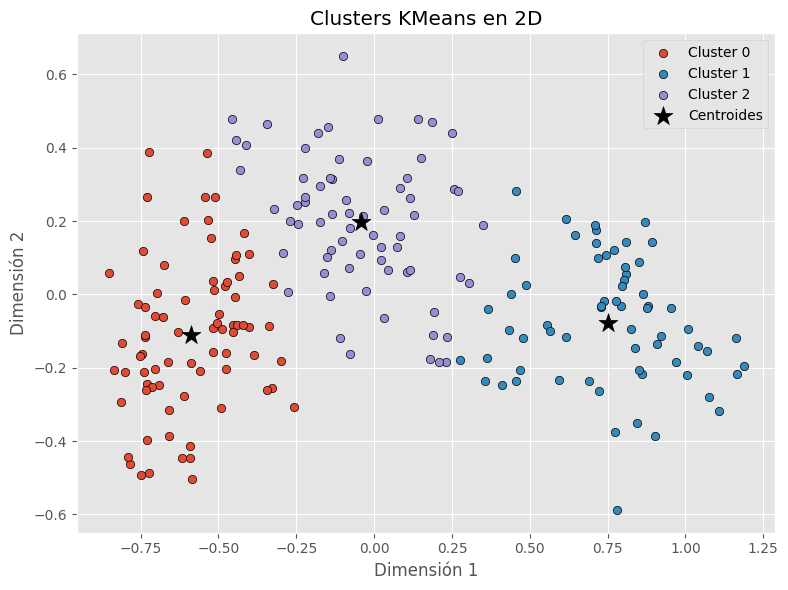

In [187]:
y_predict = plot_kmeans_2d(X_reduced, modelo_kmeans)

In [31]:
pd.crosstab(y, y_predict, dropna=False, rownames=['g_real'], colnames=['g_cluster'])

g_cluster,0,1,2
g_real,,,
1,10,2,58
2,0,62,8
3,67,0,3


Podemos comprobar que los datos han quedado separados en tres conjuntos bastante bien identificados, aunque no podemos todavía asegurar que éste será el mejor modelo.

## Hierarchical

El algoritmo de Hierarchical Clustering se basa en construir una jerarquía de agrupaciones mediante una estrategia agglomerative (de abajo hacia arriba) o divisive (de arriba hacia abajo). No requiere especificar el número de clusters (K) a priori, sino que genera un dendrograma que muestra las relaciones anidadas entre todos los puntos. El proceso comienza considerando cada punto como un cluster individual y en cada iteración fusiona los dos clusters más cercanos hasta formar un único cluster global. La elección del número final de clusters se realiza a posteriori cortando el dendrograma en un nivel específico donde la distancia entre clusters fusionados aumenta significativamente.

Vamos entonces a probar varios métodos de linkage para elegir el número de clusters correcto.


In [40]:
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering

def plot_agglomerative_dendrogram(X, method='average'):
    """
    Dibuja el dendrograma para un método de linkage dado.
    - X: array (n_samples, n_features).
    - method: uno de 'ward', 'complete', 'average' o 'single'.
    """
    Z = linkage(X, method=method)
    plt.figure(figsize=(10, 5))
    dendrogram(Z)
    plt.title(f'Dendrograma ({method} linkage)')
    plt.xlabel('Índice de muestra')
    plt.ylabel('Distancia')
    plt.tight_layout()
    plt.show()
    return Z
    
def evaluate_agglomerative_linkages(X, linkages=None, n_clusters_range=range(2, 11)):
    """
    Evalúa varios métodos de linkage calculando el silhouette score para distintos números de clusters.
    - X: array (n_samples, n_features).
    - linkages: lista de métodos de linkage (default ['ward', 'complete', 'average', 'single']).
    - n_clusters_range: rango de valores de n_clusters a probar.
    Retorna un dict con scores y grafica las curvas.
    """
    if linkages is None:
        linkages = ['ward', 'complete', 'average', 'single']
    results = {}
    plt.figure(figsize=(8, 6))

    for method in linkages:
        scores = []
        for k in n_clusters_range:
            model = AgglomerativeClustering(n_clusters=k, linkage=method)
            labels = model.fit_predict(X)
            score = silhouette_score(X, labels) if k > 1 else np.nan
            scores.append(score)
        results[method] = scores
        plt.plot(list(n_clusters_range), scores, marker='o', label=method)

    plt.title('Silhouette Scores para métodos de linkage')
    plt.xlabel('Número de clusters')
    plt.ylabel('Silhouette Score')
    plt.legend()
    plt.tight_layout()
    plt.show()

    return results


def plot_agglomerative_clusters(X_2d, modelo_agglo):
    """
    Representa los clusters de AgglomerativeClustering y sus centroides estimados.
    - X_2d: array (n_samples, 2).
    - modelo_agglo: modelo AgglomerativeClustering configurado.
    """
    labels = modelo_agglo.fit_predict(X_2d)
    centroids = np.array([X_2d[labels == l].mean(axis=0) for l in np.unique(labels)])

    fig, ax = plt.subplots(figsize=(8, 6))
    for label in np.unique(labels):
        ax.scatter(
            X_2d[labels == label, 0],
            X_2d[labels == label, 1],
            edgecolor='k',
            label=f"Cluster {label}"
        )
    ax.scatter(
        centroids[:, 0],
        centroids[:, 1],
        marker='*',
        s=200,
        c='black',
        label='Centroides estimados'
    )

    ax.set_title('Clusters Agglomerative en 2D')
    ax.set_xlabel('Dimensión 1')
    ax.set_ylabel('Dimensión 2')
    ax.legend()
    plt.tight_layout()
    plt.show()

    return labels


### Elección de linkage

Los linkages son aquellas métricas que se utilizan para fusionar los dos clusters más cercanos. Las métricas que vamos a considerar son las siguientes:
- Ward: fusiona aquellos cuya unión produzca el menor aumento en la suma de errores cuadrados.
- Complete: usa la máxima distancia entre cualquier par de puntos de los dos clusters.
- Average: calcula la distancia promedio entre todos los pares de puntos de los dos clusters.
- Single: usa la mínima distancia entre cualquier par de puntos de los dos clusters (vecino más cercano).

Para elegir el mejor linkage, vamos a utilizar su score de silueta. El que obtenga el valor máximo será el linkage elegido.

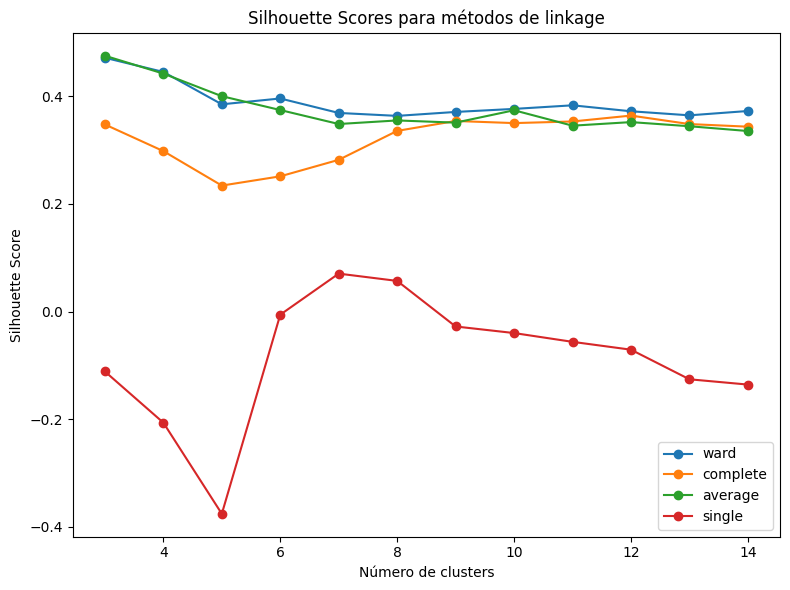

Best method: average -- Number of clusters: 3


In [33]:
linkages = ['ward', 'complete', 'average', 'single'] # ward = prog lineal ole
n_clusters = range(3, 15)
results = evaluate_agglomerative_linkages(X_reduced, linkages=linkages, n_clusters_range=n_clusters) # no hierarchical, just links

best_method = max(results, key=lambda m: max(results[m]))
best_scores = results[best_method]
opt_k = n_clusters[np.nanargmax(best_scores)]
print(f"Best method: {best_method} -- Number of clusters: {opt_k}")

Como podemos comprobar, **el linkage elegido será "average", con un total de 3 clústers.**

#### Análisis de dendograma

Un dendrograma es un diagrama de árbol que muestra el proceso de fusión (o división) de clusters en el clustering jerárquico. Representa las relaciones jerárquicas entre puntos de datos y cómo se agrupan paso a paso, desde los individuos hasta un único cluster global.

Procederemos a graficarlo y a analizar el resultado.

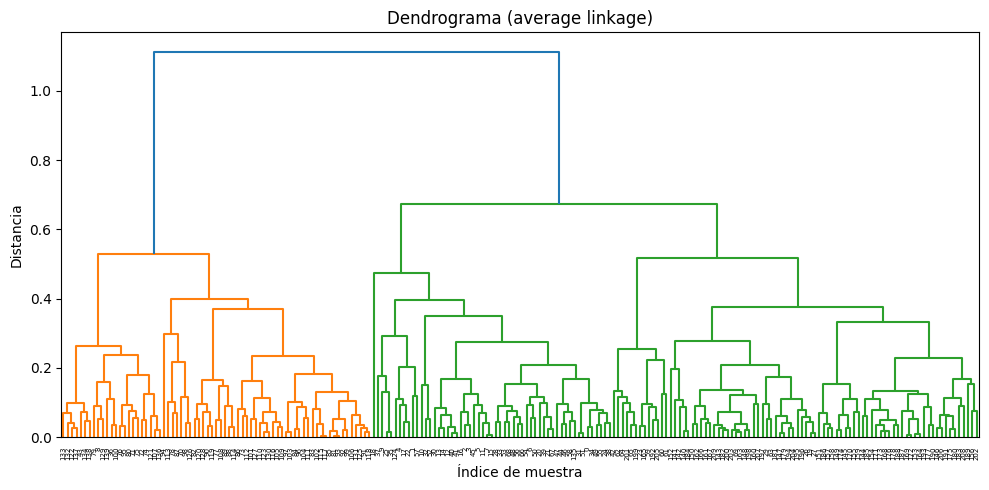

In [41]:
Z = plot_agglomerative_dendrogram(X_reduced, method=best_method)

Como podemos observar, el salto más notorio ocurre al pasar a 2 clústers. Para dejar márgen de error, podríamos considerar algún salto más. Aunque es un poco rebuscado, el método del codo y de la silhueta nos dejaban margen para llegar hasta 4 clústers, con más probabilidad de ser de 2 a 3. Es por ello que con sólo el dendograma no podemos salir de dudas, pero es evidente sinembargo que tendremos de 2 a 3 agrupaciones. Como no es claro, lo más interesante es utilizar un análisis jerárquico aglomerativo para analizar las dos opciones.

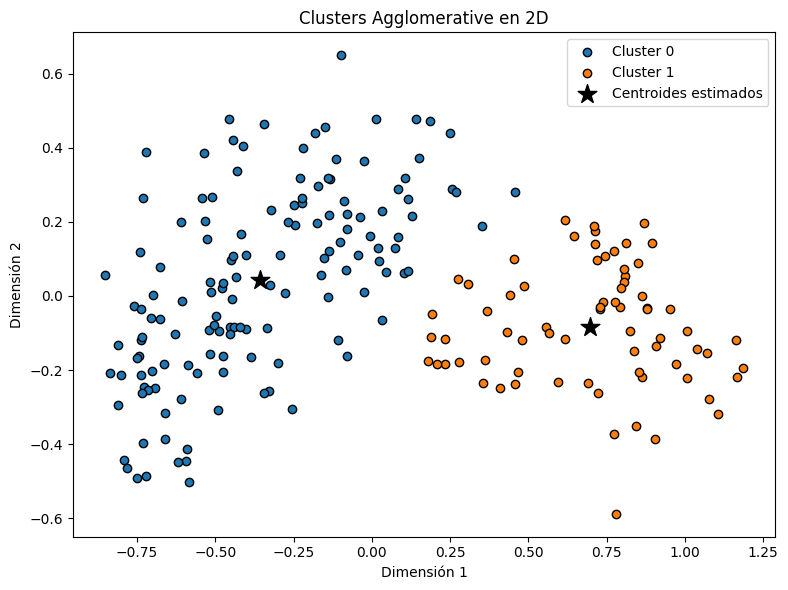

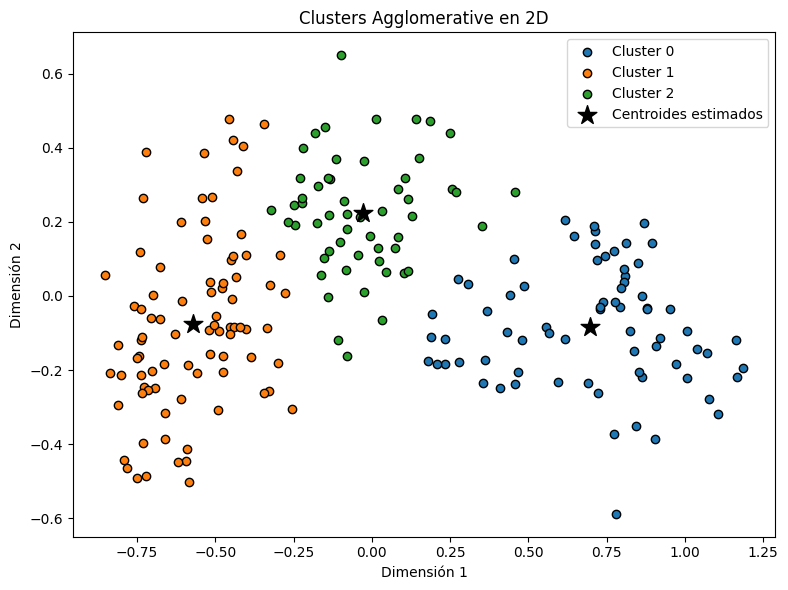

In [45]:
model_opt = AgglomerativeClustering(n_clusters=2, linkage=best_method)
labels_opt = plot_agglomerative_clusters(X_reduced, model_opt)

model_opt2 = AgglomerativeClustering(n_clusters=3, linkage=best_method)
labels_opt2 = plot_agglomerative_clusters(X_reduced, model_opt2)

Aunque es difícil de ver, hay dos líneas de separación que son perceptiblemente más anchas que el resto. La más evidente es la que separa el clúster azul de el naranja en el primer gráfico. Podríamos dibujarla mentalmente como una línea recta entre los dos clusters, que se ve de forma evidente. La segunda separación que podemos apreciar se visualiza mejor en el segundo gráfico. Es la separación entre el clúster naranja y el verde. Como vemos, aunque en una linea más sinuosa, se puede ver que hay una diferencia de anchura entre las distancias de los puntos agrupados y los separados.

Creemos conveniente por ello aceptarla como una línea valida y asumir que nos encontramos ante un problema con 3 clústers.

### DBSCAN

A pesar de que ya tenemos una idea de los grupos a los cuales nos podemos estar enfrentando, es adecuado contrastar la información utilizando un método más: DBSCAN.

DBSCAN (Agrupamiento espacial basado en densidad de aplicaciones con ruido) es un algoritmo de agrupamiento no supervisado que agrupa puntos en el espacio de datos basados en su densidad. Fnciona identificando dos tipos de puntos: 
- Puntos de núcleo, que tienen al menos un número mínimo de otros puntos (minpts) a una distancia máxima determinada (eps).
- Puntos de borde, que están dentro de la distancia de un punto de núcleo, pero no tienen el número mínimo de puntos de núcleo dentro de su vecindad.

El algoritmo expande los grupos comenzando con un punto de núcleo y agregando todos los puntos de núcleo y borde que son accesibles desde ese punto. Los puntos que no son puntos de núcleo ni puntos de borde son marcados como ruido. 

Vamos a tratar de analizar los resultados obtenidos según nuestro ajuste de los hiperparámetros minpts y eps.

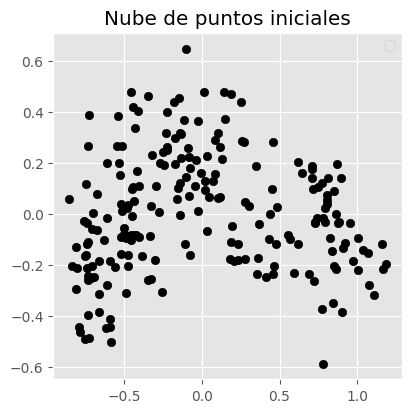

In [80]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot') or plt.style.use('ggplot')
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import scale
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')
fig, ax = plt.subplots(1, 1, figsize=(4.5, 4.5))

ax.scatter(
    x = X_reduced[:, 0],
    y = X_reduced[:, 1],
    c = 'black',
    marker    = 'o',
    edgecolor = 'black'
)
ax.legend()
ax.set_title('Nube de puntos iniciales');

Esta es nuestra nube de puntos iniciales, que debemos dividir con DBSCAN. Para ello debemos primero encontrar los hiperparámetros adecuados.

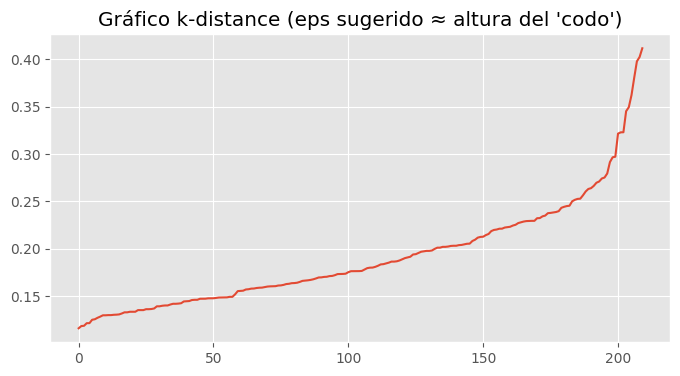

Mejores parámetros: eps=0.31421052631578944, min_samples=22, silhouette=0.3877


In [180]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from collections import Counter
import matplotlib.pyplot as plt

# 1. Escalado
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# 2. Gráfico k-distance (para guiar eps)
k = 5  # min_samples típico
nn = NearestNeighbors(n_neighbors=k)
nn.fit(X_scaled)
distances, _ = nn.kneighbors(X_scaled)
sorted_distances = np.sort(distances[:, k-1])

plt.figure(figsize=(8, 4))
plt.plot(sorted_distances)
#plt.axhline(y=0.1, color='r', linestyle='--')  # Ejemplo: línea para eps=0.1
plt.title("Gráfico k-distance (eps sugerido ≈ altura del 'codo')")
plt.show()

# 3. Búsqueda de parámetros (ajustado para 210 puntos)
best_params = {}
best_score = -1

eps_range = np.linspace(0.01, 0.35, 20)  # Rango más ajustado
min_samples_range = range(3, 30)         # Evitar valores altos

for eps in eps_range:
    for min_samples in min_samples_range:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X_scaled)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        
        if n_clusters < 2 or n_clusters > 10:  # Filtrar clusters no razonables
            continue
        
        # Calcular silhouette (ignorando outliers)
        if len(set(labels)) > 1:  # Requiere al menos 2 clusters + outliers
            score = silhouette_score(X_scaled, labels)
            if score > best_score:
                best_score = score
                best_params = {'eps': eps, 'min_samples': min_samples, 'score': score}

print(f"Mejores parámetros: eps={best_params['eps']}, min_samples={best_params['min_samples']}, silhouette={best_params['score']:.4f}")



Normalmente, el eps que se elige es aquel punto en el que la gráfica comienza a aumentar con más rapidez. En este caso lo hemos calculado automáticamente, pero podemos ver que efectivamente coincide. Tenemos por tanto un eps de 0.31.

Hemos calculado también automáticamente el minpts en base al mejor valor de la silhueta, quedándonos con un minpts de 22.

Vamos ahora a aplicar el DBSCAN con los parámetros elegidos y a graficarlo.

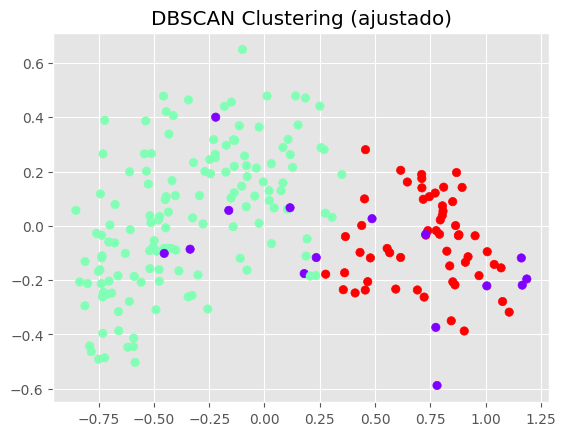

In [183]:
dbscan = DBSCAN(eps=best_params['eps'], min_samples=best_params['min_samples'])
labels = dbscan.fit_predict(X_scaled)

plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=labels, cmap='rainbow')
plt.title("DBSCAN Clustering (ajustado)")
plt.show()


Podemos ver que los resultados son dos clústers, que no es lo que esperábamos. ¿Por qué ocurre esto? Es muy sencillo: **DBSCAN no es un algoritmo apropiado para este problema.** DBSCAN se basa en la densidad de los clusters y, como podemos ver en la nube de puntos que hemos mostrado al principio, la densidad de nuestra nube es prácticamente uniforme. DBSCAN no es lo suficientemente sensible como para devolvernos el resultado que esperamos, pero al menos ha conseguido separar dos de las agrupaciones que esperábamos.

# ANÁLISIS DE LOS RESULTADOS
Una vez que hemos probado todos los métodos que conocemos, vamos a analizar cuál de ellos ha sido el más acertado. Para ello vamos a empezar por graficar los datos según la verdadera clase de las semillas.

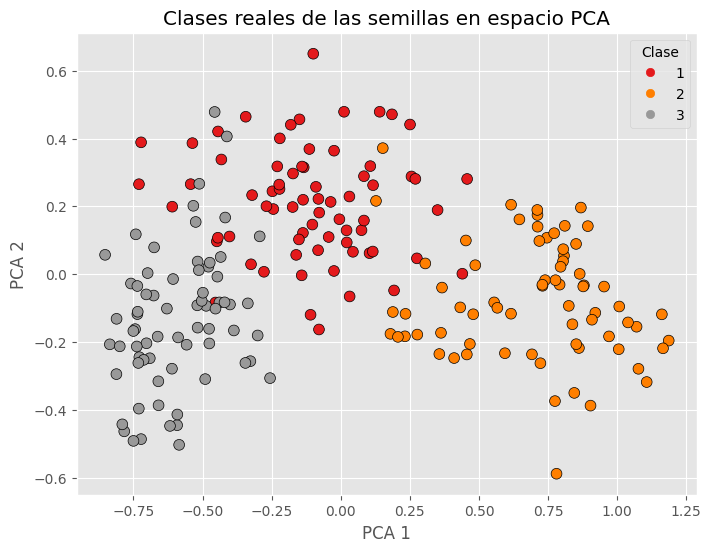

In [189]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# 1. Escalar los datos igual que en todo el proyecto
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
y_true = df['clase']
# 2. Reducción a 2D con PCA para graficar
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# 3. Graficar las clases verdaderas
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_true, cmap='Set1', edgecolor='k', s=60)
plt.title("Clases reales de las semillas en espacio PCA")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True)
plt.legend(*scatter.legend_elements(), title="Clase")
plt.show()

Como podemos comprobar, había bastante ruido en los datos y las clases estaban bastante próximas y entremezcladas, por lo que es normal que algunos métodos no dieran los resultados óptimos.

Tanto KMeans como Hierarchical Clustering han sido muy buenos candidatos y han conseguido unos resultados bastante parejos, consiguiendo separar las clases de manera correcta. Sin embargo, el dendograma utilizado en hierarchical clustering nos mostraba una separación natural de sólo dos clusters, y tuvimos que forzar demasiado la división en 3. En el caso de KMeans, sin embargo, el codo nos daba un resultado claro de 3 agrupaciones, por lo que fue la única medida que acertó.

Por tanto, **el algoritmo más acertado de forma visual para este problema es K-Means, eligiendo K con la métrica del codo.**


## ¿Por qué sólo detectábamos dos clústers en la mayoría de los casos?
Para responder a esta pregunta, debemos fijarnos en la forma en la que se distribuyen nuestros atributos según la clase de semilla a la que pertenecían.

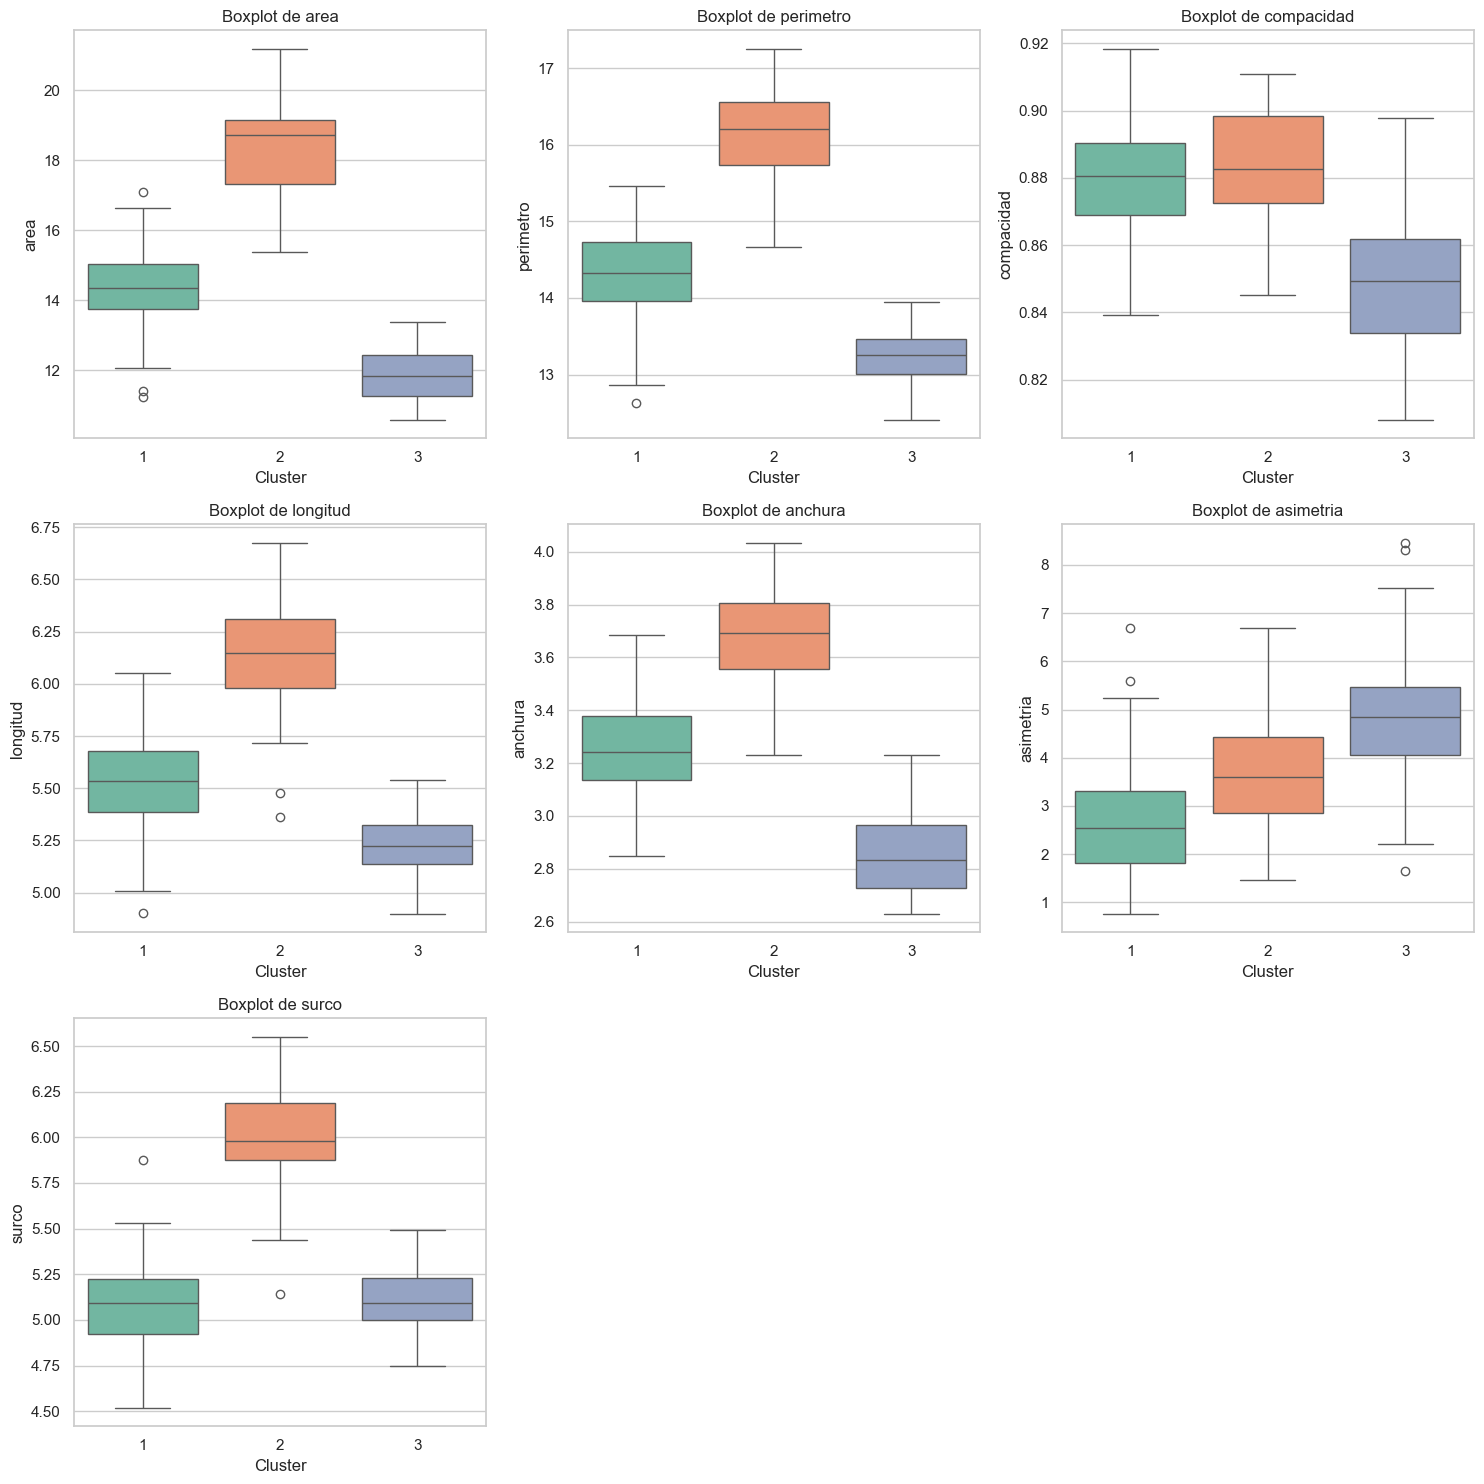

In [194]:
# Suponiendo que tienes un dataframe llamado 'df' con varios atributos y una columna 'cluster'
# que tiene el número del cluster asignado a cada punto

# Vamos a hacer un boxplot por cada atributo, comparando los valores para cada cluster
atributos = ['area', 'perimetro', 'compacidad', 'longitud', 'anchura', 'asimetria', 'surco']  # Aquí coloca los nombres de tus atributos
sns.set(style="whitegrid")  # Establece el estilo de la cuadrícula

n_atributos = len(atributos)

# Definir el número de columnas
n_cols = 3
# Calcular el número de filas necesarias
n_rows = (n_atributos + n_cols - 1) // n_cols  # Esto asegura que haya suficiente espacio

# Crear la figura y los subgráficos
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))  # Ajusta el tamaño de la figura
axes = axes.flatten()  # Aplanar la matriz de ejes para fácil indexación

# Generar los boxplots en cada subgráfico
for i, atributo in enumerate(atributos):
    sns.boxplot(x='clase', y=atributo, data=df, ax=axes[i], palette="Set2")
    axes[i].set_title(f'Boxplot de {atributo}')
    axes[i].set_xlabel('Cluster')
    axes[i].set_ylabel(atributo)

# Eliminar subgráficos vacíos si hay menos de 3 atributos por fila
for i in range(n_atributos, len(axes)):
    fig.delaxes(axes[i])

# Ajustar el espacio entre los subgráficos
plt.tight_layout()
plt.show()


Observando estos gráficos podemos comprobar que, **aunque la diferencia entre el clúster 2 (naranja) y los otros dos es bastante evidente, en la gran mayoría de atributos no hay una diferencia suficientemente grande entre los clústers 1 y 3.** La media de sus atributos está muy cerca, y los "bigotes" de sus cajas se solapan ampliamente. No es sorprendente que a la mayoría de algoritmos les costara diferenciar entre ellos.

Además, hay algunos atributos como asimetría y compacidad que se solapan muchísimo entre todos los clústers. Quizá hubiera sido interesante eliminar completamente estas características para no conducir a errores.

## Conclusión

Debido a la naturaleza de nuestro dataset, era muy complicado que los métodos pudieran acertar en la cantidad de agrupaciones y es muy probable que hubieran fallado sin conocimiento previo de los datos. Muchas semillas habrían sido clasificadas erróneamente, lo que nos enseña a tratar estos problemas con extremada cautela.